## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import pytz
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import helper
from openbb_terminal.api import openbb
from openbb_terminal.api import Portfolio
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

WARNING! Breaking changes incoming! Especially avoid using kwargs, since some of them will change.
You can try <link> branch with the latest changes.


### Header

In [2]:
theme = TerminalStyle("light", "light", "light")
stylesheet = widgets.html_report_stylesheet()
user_time_zone = pytz.timezone(helper.get_user_timezone())

In [198]:
# Parameters that will be replaced when calling this notebook
orderbook = "Public_Equity_Orderbook.xlsx"
report_name = "Portfolio Report"

In [199]:
holdings = "portfolio/holdings/"
orderbook_path = holdings + orderbook
_, orderbook_file = os.path.split(orderbook_path)
report_title = f"Portfolio report for {orderbook_file}"
report_date = pd.Timestamp.now(tz=user_time_zone).strftime("%d %B, %Y")
report_time = pd.Timestamp.now(tz=user_time_zone).strftime("%H:%M")
report_timezone = pd.Timestamp.now(tz=user_time_zone).tzinfo
report_title, report_date, report_time, report_timezone

('Portfolio report for Public_Equity_Orderbook.xlsx',
 '15 September, 2022',
 '06:03',
 <DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>)

## Data

Loading

In [200]:
try:
    transactions = Portfolio.read_orderbook(orderbook_path)

    P = Portfolio(transactions)
    P.generate_portfolio_data()
    P.load_benchmark()
    P.get_orderbook()
except ValueError:
    raise ValueError(
        "Failed to load the orderbook. Is this file inside the 'Holdings' folder?"
    )

Preprocessing orderbook:

.

.

.

.

.

.

.

.

.

.

.

.

Loading company data:

.

Loading price data:

.

Calculating returns:

.

Loading benchmark:

.

Expected list of one axis items.


1 axes expected.

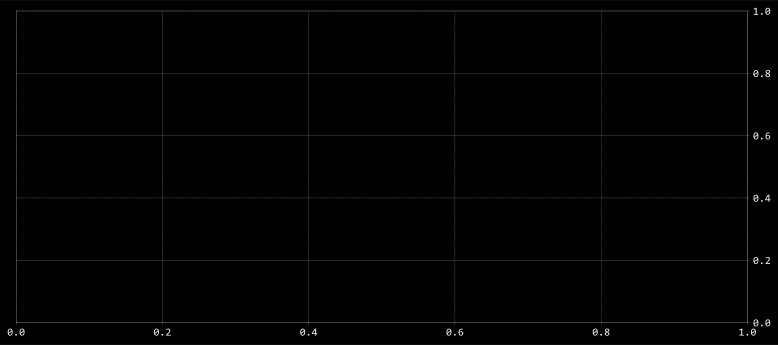

In [173]:
# fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
# ax2 = ax1.twinx()
# openbb.portfolio.rbeta(P, chart=True, external_axes=[ax1, ax2])

# fig.tight_layout()
# f = io.BytesIO()
# fig.savefig(f, format="svg")
# beta_chart = f.getvalue().decode("utf-8")

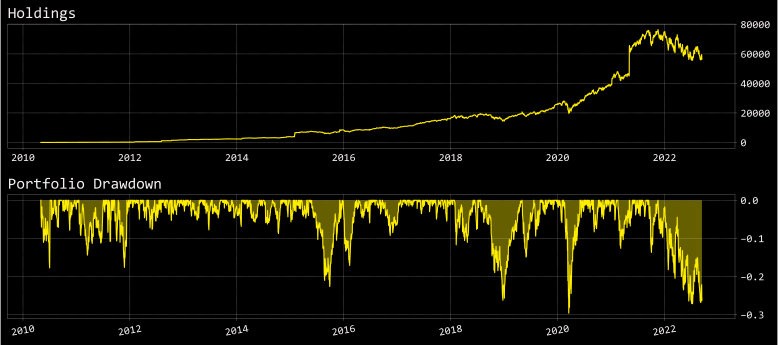

In [174]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.portfolio.maxdd(P, chart=True, external_axes=ax)

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
maxdd_chart = f.getvalue().decode("utf-8")

In [72]:
P.calculate_allocations("country")

country_allocation = pd.DataFrame(
    [P.portfolio_country_allocation, P.benchmark_country_allocation]
).T
country_allocation.columns = ["Portfolio", "Benchmark"]
country_allocation.fillna("-", inplace=True)
country_allocation["Portfolio"] = (country_allocation["Portfolio"] * 100).map(
    "{:.3}%".format
)
country_allocation["Benchmark"] = (country_allocation["Benchmark"] * 100).map(
    "{:.3}%".format
)

country_allocation

,Portfolio,Benchmark
Netherlands,37.9%,0.13%
United States,32.0%,99.0%
Taiwan,14.5%,---%
China,10.2%,---%
Germany,5.47%,---%
United Kingdom,---%,0.5%
Switzerland,---%,0.33%
Singapore,---%,0.04%


In [75]:
P.calculate_allocations("sector")

sector_allocation = pd.DataFrame(
    [P.portfolio_sectors_allocation, P.benchmark_sectors_allocation]
).T
sector_allocation.columns = ["Portfolio", "Benchmark"]
sector_allocation.fillna("-", inplace=True)
sector_allocation["Portfolio"] = (sector_allocation["Portfolio"] * 100).map(
    "{:.3}%".format
)
sector_allocation["Benchmark"] = (sector_allocation["Benchmark"] * 100).map(
    "{:.3}%".format
)

sector_allocation

Loading sector data:

,Portfolio,Benchmark
Technology,60.7%,25.2%
Consumer Cyclical,28.0%,11.3%
Healthcare,9.84%,14.4%
Communication Services,1.48%,8.41%
Financial Services,---%,12.8%
Industrials,---%,8.35%
Consumer Defensive,---%,7.02%
Energy,---%,4.37%
Realestate,---%,2.89%
Utilities,---%,2.45%


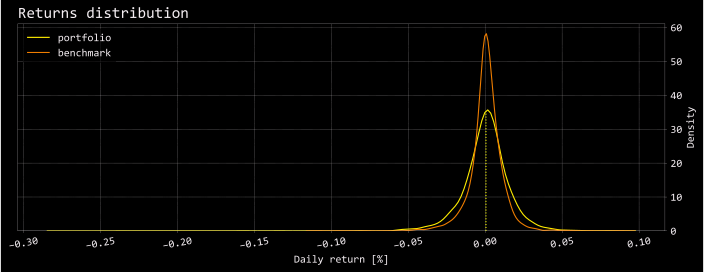

In [116]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
openbb.portfolio.distr(P, chart=True, external_axes=ax)

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
distr_chart = f.getvalue().decode("utf-8")

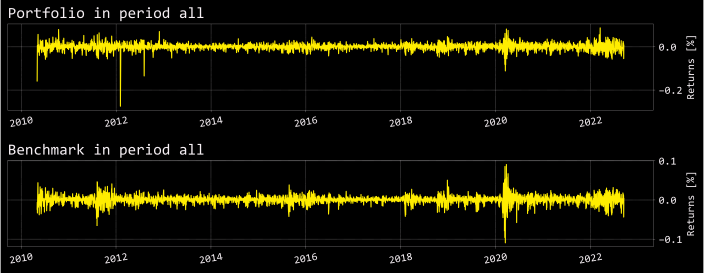

In [131]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), dpi=150)
openbb.portfolio.dret(P, chart=True, external_axes=[ax1, ax2])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
dret_chart = f.getvalue().decode("utf-8")

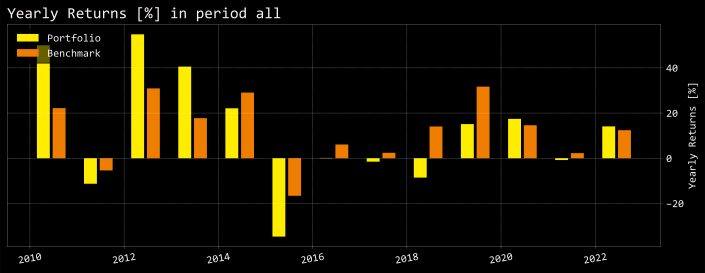

In [108]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
openbb.portfolio.yret(P, chart=True, external_axes=ax)

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
yret_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [197]:
from glob import escape


body = ""

img = "./openbb_terminal/reports/OpenBB_reports_logo.png"
floppy_disk_img = ("./openbb_terminal/reports/floppy-disc.png",)
body += widgets.header(
    img,
    floppy_disk_img,
    "OpenBB",
    report_date,
    report_time,
    report_timezone,
    report_title,
)

body += widgets.tablinks(["Summary", "In-Depth Analysis", "Statistics"])

# Summary
htmlcode = widgets.p(
    "The total performance of the portfolio versus the benchmark is as follows. "
    "Please note this calculation assumes partially shares exist for the benchmark."
)

htmlcode += widgets.row(
    [widgets.h(3, "Performance") + openbb.portfolio.perf(P).to_html()]
)

htmlcode += widgets.p("In which the following yearly returns are achieved")

htmlcode += widgets.row([widgets.h(3, "Yearly Performance") + yret_chart])

htmlcode += widgets.p(
    "The portfolio and benchmark consists of the following allocations to countries, sectors and industries"
)

htmlcode += widgets.row(
    [widgets.h(3, "Country Allocation") + country_allocation.to_html()]
)

htmlcode += widgets.row(
    [widgets.h(3, "Sector Allocation") + sector_allocation.to_html()]
)

htmlcode += widgets.p(
    "The portfolio consists of the following trades including returns"
)

htmlcode += widgets.row(
    [widgets.h(3, "Portfolio Trades") + P.portfolio_trades.to_html()]
)

htmlcode += widgets.p(
    "The benchmark consists of the following trades including returns"
)

htmlcode += widgets.row(
    [widgets.h(3, "Benchmark Trades") + P.benchmark_trades.to_html()]
)

body += widgets.add_tab("Summary", htmlcode)

# In Depth Analysis
htmlcode = widgets.p(
    "The following metrics, Tracking Error and Information Ratio, measure whether you are "
    "closely aligned with the benchmark. If the Tracking Error is not close to 1, a different benchmark "
    "might be a better fit."
)

htmlcode += widgets.row(
    [widgets.h(3, "Tracking Error") + openbb.portfolio.trackerr(P)[0].to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Information Ratio") + openbb.portfolio.information(P).to_html()]
)

htmlcode += widgets.row([widgets.h(3, "Maximum Drawdown") + maxdd_chart])

htmlcode += widgets.row(
    [widgets.h(3, "Sharpe Ratio") + openbb.portfolio.sharpe(P).to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Common Sense Ratio") + openbb.portfolio.commonsense(P).to_html()]
)

body += widgets.add_tab("In-Depth Analysis", htmlcode)

# Statistics
htmlcode = widgets.row([widgets.h(3, "Distribution") + distr_chart])
htmlcode += widgets.row([widgets.h(3, "Daily Returns") + dret_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Volatility") + openbb.portfolio.volatility(P).to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Kurtosis") + openbb.portfolio.kurtosis(P).to_html()]
)
htmlcode += widgets.row([widgets.h(3, "Skew") + openbb.portfolio.skew(P).to_html()])
htmlcode += widgets.row(
    [widgets.h(3, "Value at Risk (VaR)") + openbb.portfolio.var(P).to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Expected Shortfall (cVaR)") + openbb.portfolio.es(P).to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Omega Ratio") + openbb.portfolio.om(P).to_html()]
)

body += widgets.add_tab("Statistics", htmlcode)

body += widgets.tab_clickable_and_save_evt()

report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

NameError: name 'performance' is not defined

In [202]:
openbb.portfolio.perf(P)

,Portfolio,Benchmark,Difference
Total Investment,48693.95,48693.95,-
Total Value,56729.890381,62650.767742,-5920.877361
Total % Return,16.50%,28.66%,-12.16%
Total Abs Return,8035.940381,13956.817742,-5920.877361


In [204]:
openbb.portfolio.information(P)

,Information Ratio
mtd,-2.053
qtd,-5.606
ytd,-19.076
3m,-8.540
6m,-4.834
1y,-20.269
3y,-0.104
5y,1.261
10y,-5.980
all,-11.054
